In [1]:
using FFTW
using BenchmarkTools

In [2]:

function fft_1dgpt(x::AbstractVector{Complex{T}}) where T<:AbstractFloat
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = copy(x)

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end
function fft_1dgpt(x::AbstractVector{T}) where T<:AbstractFloat
    return fft_1dgpt(complex.(x))
end

function fft_1dgpt(x) 
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = copy(x)

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

fft_1dgpt (generic function with 3 methods)

In [21]:
"""
    fft_1dgpt_real!(x_re, x_im)

In-place FFT on two real-valued vectors `x_re`, `x_im`.
Both must be the same length `N` (a power of two).
The input in `x_im` is usually all zeros (for real input).
After this call, `x_re` and `x_im` hold the real and imaginary parts
of the FFT, suitable for use in JuMP @NLobjective.
"""
function fft_1dgpt!(x_re::AbstractVector{T}, x_im::AbstractVector{T}) where {T<:AbstractFloat}
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    @inbounds for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end


fft_1dgpt!

In [4]:
function fft_2dcustom(A::AbstractMatrix{Complex{T}}) where T<:AbstractFloat
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = similar(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dgpt(view(A, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dgpt(view(B, y, :))
    end

    return B
end

function fft_2dcustom(A::AbstractMatrix{T}) where T<:AbstractFloat
    return fft_2dcustom(Complex{T}.(A))
end

fft_2dcustom (generic function with 2 methods)

In [ ]:
function fftshift_custom!(dest::AbstractArray,x::AbstractArray)
    # Calculate the shift amount for each dimension
    shifts = map(s -> div(s, 2), size(x))
    circshift!(dest,x, shifts)    
    return nothing
end

# Inverse operation
function ifftshift_custom!(dest::AbstractArray,x::AbstractArray)
    shifts = map(s -> -div(s, 2), size(x))
    circshift!(dest, x, shifts)
    return nothing
end

ifftshift_custom! (generic function with 2 methods)

In [5]:
A = rand(1024, 1024) + im * rand(1024, 1024)
B = rand(1024, 1024);

In [6]:
A_fft_custom = fft_2dcustom(A)
B_fft_custom = fft_2dcustom(B)
A_fft_fftw = fft(A)
B_fft_fftw = fft(B)
@assert A_fft_custom ≈ A_fft_fftw
@assert B_fft_custom ≈ B_fft_fftw

In [26]:
methods(circshift!)

# 11 methods for generic function "circshift!" from Base:
  [1] circshift!(dest::BitVector, src::BitVector, i::Integer)
     @ bitarray.jl:1423
  [2] circshift!(B::BitVector, i::Integer)
     @ bitarray.jl:1442
  [3] circshift!(O::SparseArrays.SparseVector, X::SparseArrays.SparseVector, ::Tuple{Integer})
     @ SparseArrays /opt/julia-1.11.2/share/julia/stdlib/v1.11/SparseArrays/src/sparsevector.jl:2409
  [4] circshift!(O::SparseArrays.SparseVector, X::SparseArrays.SparseVector, r::Real)
     @ SparseArrays /opt/julia-1.11.2/share/julia/stdlib/v1.11/SparseArrays/src/sparsevector.jl:2415
  [5] circshift!(O::SparseArrays.AbstractSparseMatrixCSC, X::SparseArrays.AbstractSparseMatrixCSC, ::Tuple{Integer, Integer})
     @ SparseArrays /opt/julia-1.11.2/share/julia/stdlib/v1.11/SparseArrays/src/sparsematrix.jl:4350
  [6] circshift!(O::SparseArrays.AbstractSparseMatrixCSC, X::SparseArrays.AbstractSparseMatrixCSC, ::Tuple{Integer})
     @ SparseArrays /opt/julia-1.11.2/share/julia/stdlib/v1.11/SparseArrays/src/sparsematrix.jl:4388
  [7] circshift!(O::SparseArrays.AbstractSparseMatrixCSC, X::SparseArrays.AbstractSparseMatrixCSC, r::Real)
     @ SparseArrays /opt/julia-1.11.2/share/julia/stdlib/v1.11/SparseArrays/src/sparsematrix.jl:4389
  [8] circshift!(a::AbstractVector, shift::Integer)
     @ abstractarray.jl:3658
  [9] circshift!(dest::AbstractArray, src, ::Tuple{})
     @ multidimensional.jl:1205
 [10] circshift!(dest::AbstractArray{T, N}, src, shiftamt::NTuple{N, Integer} where N) where {T, N}
     @ multidimensional.jl:1216
 [11] circshift!(dest::AbstractArray, src, shiftamt)
     @ multidimensional.jl:1224

In [36]:
A1 = rand(1024, 1024+3) + im * rand(1024, 1024+3)
a_cumstom = copy(A1)
a_fft = copy(A1)
dest = copy(A1)
fftshift_custom!(dest,a_fft)
fftshift_custom!(dest,a_fft)
@assert fftshift(a_cumstom) ≈ dest
@benchmark fftshift_custom!(dest, a_fft)

BenchmarkTools.Trial: 1483 samples with 1 evaluation per sample.
 Range (min … max):  2.105 ms …   5.980 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.268 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.355 ms ± 926.125 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄█▄                                                         
  ▆███▇▆▆▆▆▅▃▄▄▅▆█▅▇▆▇▅▅▇▇▇▇▇▅▄▄▅▅▄▅▅▅▆▇▆▅▃▅▄▃▄▃▃▃▃▃▃▃▁▄▃▃▃▃▃ ▄
  2.1 ms          Histogram: frequency by time        5.64 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [37]:
@benchmark fftshift(a_cumstom)

BenchmarkTools.Trial: 1399 samples with 1 evaluation per sample.
 Range (min … max):  2.272 ms …  10.258 ms  ┊ GC (min … max):  0.00% … 11.78%
 Time  (median):     3.586 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.560 ms ± 770.248 μs  ┊ GC (mean ± σ):  10.03% ± 11.46%

    ▄             ▅█▅       ▃▅▃                                
  ▃▆█▇▄▃▅▃▃▃▂▃▂▂▃▆███▇▆▇▅▄▆▆████▆▇▇▆▅▄▄▄▆▅█▇▆▄▃▄▂▃▃▁▃▂▂▃▃▃▃▃▃ ▄
  2.27 ms         Histogram: frequency by time        5.22 ms <

 Memory estimate: 16.05 MiB, allocs estimate: 3.

In [38]:
@benchmark fftshift!(dest,a_cumstom)

BenchmarkTools.Trial: 1513 samples with 1 evaluation per sample.
 Range (min … max):  2.084 ms …   6.384 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.288 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.288 ms ± 819.287 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ██               ▁▂▁ ▁▂▁                                   
  ▄▇██▆▆▆▆▅▅▄▃▄▄▃▅▅▃▅███▇███▆█▇▆▄▆▄▅▄▄▄▃▃▃▄▄▃▃▃▃▂▂▃▃▂▂▂▂▁▁▁▁▂ ▃
  2.08 ms         Histogram: frequency by time         5.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

0

In [8]:
test = ones(8, 8)
test_fft = fftshift(fft(test))
test_fft_custom = fftshift(fft_2dcustom(test))
println(test_fft ≈ test_fft_custom)
heatmap(abs2.(fftshift(fft_2dcustom(test))), title="Custom FFT 2D", xlabel="Frequency X", ylabel="Frequency Y")

true


UndefVarError: UndefVarError: `heatmap` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
a = Complex.(rand(1024)) .+ im .* Complex.(rand(1024))
a_fft_custom = fft(a);
@benchmark fft(a)

BenchmarkTools.Trial: 10000 samples with 5 evaluations per sample.
 Range (min … max):   6.009 μs …  3.792 ms  ┊ GC (min … max): 0.00% … 33.45%
 Time  (median):      6.981 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.373 μs ± 55.333 μs  ┊ GC (mean ± σ):  5.56% ±  1.41%

  ▁▄▇█▆▅▄▄▃▃▂▂▁▁▁▁▁▁ ▁▁ ▁▁▁▂▃▃▃▃▂▂▂▂▂▁▁                       ▂
  ████████████████████████████████████████▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▅▅ █
  6.01 μs      Histogram: log(frequency) by time      19.4 μs <

 Memory estimate: 16.33 KiB, allocs estimate: 8.

In [22]:
reals = real.(a)
imags = imag.(a)
@benchmark fft_1dgpt!(reals, imags)
# @assert reals ≈ real.(a_fft_custom)
# @assert imags ≈ imag.(a_fft_custom)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  42.539 μs … 78.187 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     46.567 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   47.203 μs ±  3.331 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▅                  █                                 
  ▂▄▃▅▄▃▄▃█▄▄▃▄▆▇▆▃▄█▃▂▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  42.5 μs         Histogram: frequency by time          60 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [11]:
println(imags[1:10])
println(imag.(a_fft_custom)[1:10])

[0.8285304472569426, 0.851857007404441, 0.1592271527401642, 0.7794039528900412, 0.16614725398876395, 0.22262794209526726, 0.9695421109047757, 0.6894412890876838, 0.9395922092962491, 0.8861822686815922]
[517.0169627377404, 24.344073851918537, -9.594306241927015, 13.110364012337032, -8.722020496715219, 6.713355713884441, -2.9990449691718357, 3.260948477454004, -6.136491623512576, -16.615056922515482]


In [12]:
@benchmark fft_1dgpt(a)

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  11.612 μs …  1.673 ms  ┊ GC (min … max): 0.00% … 97.49%
 Time  (median):     12.193 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.202 μs ± 16.708 μs  ┊ GC (mean ± σ):  1.24% ±  0.97%

  ▁▅▇██▆▅▃▂▂▂▁▂▁▁▂▁▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁                   ▂
  ████████████████████████████████████████████▇▇▇▇▇▆▇▇▆▅▆▆▄▄▅ █
  11.6 μs      Histogram: log(frequency) by time      19.4 μs <

 Memory estimate: 16.06 KiB, allocs estimate: 3.

In [13]:
@benchmark fft(a)

BenchmarkTools.Trial: 10000 samples with 5 evaluations per sample.
 Range (min … max):   6.474 μs …  3.649 ms  ┊ GC (min … max): 0.00% … 23.58%
 Time  (median):      7.388 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.515 μs ± 54.387 μs  ┊ GC (mean ± σ):  5.27% ±  1.47%

  ▁▅██▆▅▄▄▄▃▃▃▃▂▁▁▁▁ ▁  ▁ ▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁                     ▂
  ██████████████████████████████████████████▇█▇▇█▇▇▆▇▆▆▇▅▅▅▅▅ █
  6.47 μs      Histogram: log(frequency) by time      19.8 μs <

 Memory estimate: 16.33 KiB, allocs estimate: 8.

In [14]:
@benchmark fft_2dcustom(A)

BenchmarkTools.Trial: 100 samples with 1 evaluation per sample.
 Range (min … max):  44.359 ms … 116.520 ms  ┊ GC (min … max): 0.00% … 56.32%
 Time  (median):     47.388 ms               ┊ GC (median):    3.68%
 Time  (mean ± σ):   50.178 ms ±  11.397 ms  ┊ GC (mean ± σ):  7.33% ± 10.15%

  ▃▅▆█▅▃▁                                                       
  ███████▅▁▁▁▁▁▁▅▁▅▁▁▁▅▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▁▅ ▅
  44.4 ms       Histogram: log(frequency) by time      99.9 ms <

 Memory estimate: 48.13 MiB, allocs estimate: 6147.

In [15]:
@benchmark fft(A)

BenchmarkTools.Trial: 123 samples with 1 evaluation per sample.
 Range (min … max):  37.039 ms … 62.632 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     39.345 ms              ┊ GC (median):    1.62%
 Time  (mean ± σ):   40.830 ms ±  4.544 ms  ┊ GC (mean ± σ):  1.80% ± 1.59%

     ▅█▆▇                                                      
  ▅▅▆████▆▆▃▃▄▁▃▁▃▃▃▃▁▁▃▁▁▄▁▄▁▁▁▃▁▁▃▁▃▁▁▁▁▁▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▃▁▃ ▃
  37 ms           Histogram: frequency by time        60.4 ms <

 Memory estimate: 16.00 MiB, allocs estimate: 8.

In [16]:
using Plots
using JuMP
using Ipopt

ArgumentError: ArgumentError: Package JuMP not found in current path.
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.

In [17]:
struct MinimizingFunc
    x::Vector{Float64}
    y_data::Vector{Float64}
    # amk::Array{Any, 3}
    # params::Vector{Float64}
end
function (pv::MinimizingFunc)(m, b)

   
    model_real = @. sin(m*pv.x) + b
    model_imag = model_real.*zero(model_real)


    

    fft_1dgpt!(model_real, model_imag)
    # model_abs = @. sqrt(model_real^2 + model_imag^2)
    # half_real = model_fft[1:2:end]

    
    obj = sum((model_real .- pv.y_data).^2)

    return obj
end

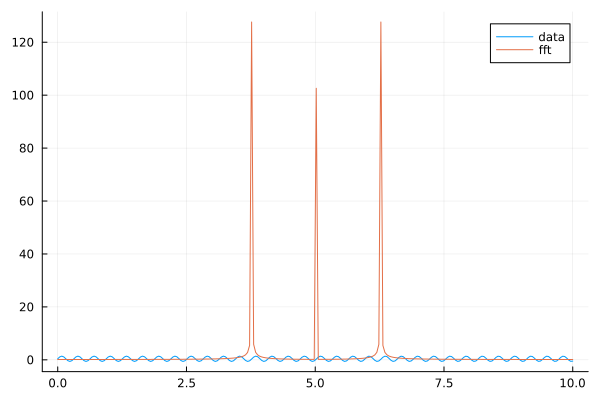

In [18]:
N = 2^8
amk = Array{Any}(undef, N)
z::Vector{Float64} = LinRange(0, 10, N)
m = 20
b = 0.4
# x = 0:0.1:10
noise = randn(length(z))
y = @. sin(m*z) + b 
y_fft = abs.(fftshift(fft(y)))




plot(z, y, label="data")
plot!(z, y_fft, label="fft")

In [19]:
model = Model(Ipopt.Optimizer)
set_silent(model)
ConstraintFunc = MinimizingFunc(z, y_fft)

q = @variable(model, start=m)
p = @variable(model, start=b)
# ams = @expression(model, ConstraintFunc(φ))

# @constraint(model, ams[1] == ams[2])


@objective(model, Min, ConstraintFunc(q,p))
optimize!(model)

UndefVarError: UndefVarError: `Model` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
q_sol = value(q)
p_sol = value(p)
println("Solution:")
println("q = ", q_sol)
println("p = ", p_sol)
model_fit = @. sin(q_sol*z) + .1
model_fit_fft = abs.(fftshift(fft(model_fit)))
plot(z, model_fit_fft, label="model fit", linestyle=:dash)
plot!(z, y_fft, label="fft")


UndefVarError: UndefVarError: `value` not defined in `Main`
Suggestion: check for spelling errors or missing imports.